# Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping 
import gensim
from gensim.models import KeyedVectors
from gensim.models import word2vec
from utility import ar_preprocessing
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# **Read Data**

***Convert txt file to csv***

In [2]:
data = pd.read_csv('all.dev.features.txt', sep=' ')
  
data.to_csv('all.dev.features.csv', index = None)

***As Documentaion say, data columns represnts the following info:***


0. Token (T1,T2,...Tn-1, Tn)
1. T1
2. Tn
3. T1,T2
4. Tn-1,Tn
5. T1,T2,T3
6. Tn-2,Tn-1,Tn
7. T2,T3
8. Tn-2,Tn-1
9. T2,T3,T4
10. Tn-3,Tn-2,Tn-1
11. T3,T4
12. Tn-4,Tn-3
13. token length
14. is the word's gloss translation capitalized?
15. POS
16. case
17. aspect
18. number
19. person
20. gender
21. state
22. normalized spelling (romanized)
23. is there a mada analysis
24. is the word Arabic UTF-8 (vs. Latin)
25. is base form same as the normalized form
26. Wikipedia: is this a hyperlink or regular text (noisy; turned off)
27. Wikipedia dict: noisy (noisy; turned off)
28. is the token utf-8 or ascii (noisy; turned off)
29. does the term have any vowels (noisy; turned off)
30. is the token in Wiki NE dict
31. is curr+next token in Wiki NE dict
32. is curr+prev token in Wiki NE dict
33. is the token in Wiki non-NE dict
34. is curr+next token in Wiki non-NE dict
35. is curr+prev token in Wiki non-NE dict
36. class


***So we'll choose the following columns (0, 24, 36) that represent (token, is arabic ?, class).***

In [3]:
data = pd.read_csv("all.dev.features.csv", delimiter='\t', header=None, usecols=[0, 24, 36])
data.rename(columns={0:'Word', 24:'Arabic', 36:'Label'}, inplace=True)
data

,Word,Arabic,Label
0,الذرة,1.0,O
1,هي,1.0,O
2,أصغر,1.0,O
3,جزء,1.0,O
4,من,1.0,O
...,...,...,...
21198,BSD,0.0,I-MIS
21199,في,1.0,O
21200,طور,1.0,O
21201,التصميم,1.0,O


# **Explore Data**

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21203 entries, 0 to 21202
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Word    21203 non-null  object 
 1   Arabic  20992 non-null  float64
 2   Label   20992 non-null  object 
dtypes: float64(1), object(2)
memory usage: 497.1+ KB


In [5]:
data.drop('Arabic', axis=1).describe()

,Word,Label
count,21203,20992
unique,6927,9
top,.,O
freq,609,17641


In [6]:
data.Word.value_counts()

.        609
في       606
من       511
،        453
و        360
        ... 
حساس       1
تشبع       1
للحد       1
أقسام      1
ستجد       1
Name: Word, Length: 6927, dtype: int64

# **Data Cleaning**

***Remove Non Arabic words***

In [7]:
data = data[data['Arabic'] == 1]
data

,Word,Arabic,Label
0,الذرة,1.0,O
1,هي,1.0,O
2,أصغر,1.0,O
3,جزء,1.0,O
4,من,1.0,O
...,...,...,...
21197,/,1.0,I-MIS
21199,في,1.0,O
21200,طور,1.0,O
21201,التصميم,1.0,O


***We used 'Arabic' column to identify Non Arabic words and delelete them.So, now we don't need it.***

***Drop Arabic Column***

In [8]:
data = data.drop(['Arabic'], axis=1)
data

,Word,Label
0,الذرة,O
1,هي,O
2,أصغر,O
3,جزء,O
4,من,O
...,...,...
21197,/,I-MIS
21199,في,O
21200,طور,O
21201,التصميم,O


# **Data Preprocessing**

***Preprocess Arabic Words***

In [9]:
data['Word'] = data['Word'].apply(ar_preprocessing)
data

,Word,Label
0,الذره,O
1,هي,O
2,اصغر,O
3,جزء,O
4,من,O
...,...,...
21197,,I-MIS
21199,في,O
21200,طور,O
21201,التصميم,O


***ar_preprocessing() Function causes some empty values (" "),Pandas will not recognise them because they are not "null". To fix this, We'll convert the empty stings to np.nan objects using replace(), and then call dropna() to delete rows with "null" values.***

In [10]:
nan_value = float("NaN")
data = data.replace("", nan_value)
data = data.dropna()

In [11]:
data

,Word,Label
0,الذره,O
1,هي,O
2,اصغر,O
3,جزء,O
4,من,O
...,...,...
21193,تشغيل,I-MIS
21194,باسم,O
21199,في,O
21200,طور,O


In [12]:
data.reset_index(drop=True, inplace=True)
data

,Word,Label
0,الذره,O
1,هي,O
2,اصغر,O
3,جزء,O
4,من,O
...,...,...
18956,تشغيل,I-MIS
18957,باسم,O
18958,في,O
18959,طور,O


In [13]:
len(data['Word'].values)

18961

***Explore Data after cleaning and preprocessing***

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18961 entries, 0 to 18960
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Word    18961 non-null  object
 1   Label   18961 non-null  object
dtypes: object(2)
memory usage: 296.4+ KB


In [15]:
data.describe()

,Word,Label
count,18961,18961
unique,6451,9
top,في,O
freq,606,16290


In [16]:
data.Word.value_counts()

في          606
من          511
و           360
علي         255
الي         161
           ... 
والعوامل      1
وارسلت        1
وفجر          1
حرث           1
ستجد          1
Name: Word, Length: 6451, dtype: int64

# **Data Preparing**

***Encode Words (Tokens)***

In [17]:
# prepare tokenizer
t = Tokenizer()
words = data['Word'].values
t.fit_on_texts(words)
vocab_size = len(t.word_index) + 1
print('vocab_size:\n',vocab_size)
# integer encode the words
encoded_words = t.texts_to_sequences(words)
print('encoded_words:\n',encoded_words)

# pad documents to a max length of # words
max_length = 1
padded_words = pad_sequences(encoded_words, maxlen=max_length, padding='post')
print('padded_docs:\n',padded_words)

vocab_size:
 6435
encoded_words:
 [[42], [46], [288], [414], [2], [249], [657], [15], [2247], [2248], [658], [415], [249], [659], [888], [514], [168], [5], [660], [1310], [1311], [1312], [169], [1313], [2249], [250], [17], [2250], [182], [661], [2251], [27], [59], [288], [2], [42], [289], [42], [2], [2252], [2], [2253], [1314], [], [60], [], [2254], [224], [102], [515], [889], [662], [225], [1], [890], [289], [68], [891], [29], [2], [892], [515], [889], [3], [663], [1315], [42], [46], [288], [414], [2], [249], [98], [6], [893], [148], [25], [664], [1316], [250], [665], [2255], [69], [1], [226], [2256], [2257], [894], [895], [516], [149], [1317], [52], [345], [3], [103], [896], [39], [1317], [52], [897], [1], [168], [2258], [3], [897], [103], [1], [168], [346], [666], [8], [168], [67], [345], [103], [42], [517], [1318], [2], [2259], [55], [2260], [2261], [2262], [898], [1319], [2263], [52], [251], [252], [3], [52], [2264], [252], [899], [253], [], [2265], [900], [], [3], [48], [52], [66

***Encode Labels***

In [18]:
labels = data['Label'].values
label_encoder = preprocessing.LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)
print('Unique encoded_labels:\n',np.unique(encoded_labels))

Unique encoded_labels:
 [0 1 2 3 4 5 6 7 8]


# **Split data**

In [19]:
X_train, X_test, Y_train, Y_test = train_test_split(padded_words, encoded_labels, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(17064, 1) (17064,)
(1897, 1) (1897,)


# **Word2vec Model**

**Download model zip file, unzip it**

In [20]:
# !wget https://bakrianoo.ewr1.vultrobjects.com/aravec/full_grams_sg_300_wiki.zip
# !unzip "/content/full_grams_sg_300_wiki.zip" -d "/content/"

**Load Model**

In [21]:
w2v_model = KeyedVectors.load('/content/full_grams_sg_300_wiki.mdl')

***662,109 words with 300 dimensions represent every word.***

In [22]:
w2v_model.wv.vectors.shape

(662109, 300)

***load the whole embedding into memory***


In [23]:
w2v_embeddings_index={}
TOTAL_EMBEDDING_DIM=300

for word in w2v_model.wv.vocab:
    w2v_embeddings_index[word] = w2v_model[word]
    
print('Loaded %s word vectors.'% len(w2v_embeddings_index))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


Loaded 662109 word vectors.


***create a weight matrix for words in corpus***

In [24]:
embedding_matrix = np.zeros((vocab_size, TOTAL_EMBEDDING_DIM))

for word, i in t.word_index.items():
    embedding_vector = w2v_embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
print('Embedding Matrix shape:', embedding_matrix.shape)

Embedding Matrix shape: (6435, 300)


In [25]:
embedding_layer = tf.keras.layers.Embedding(vocab_size, TOTAL_EMBEDDING_DIM, weights=[embedding_matrix], input_length=1, trainable=False)

# **LSTM**

***define model***

In [26]:
input_placeholder= tf.keras.Input(shape=(1,), dtype='int32')
input_embedding = embedding_layer(input_placeholder)
lstm= tf.keras.layers.LSTM(units=10, activation='relu')(input_embedding)
preds = tf.keras.layers.Dense(9, activation='softmax', name = 'activation')(lstm)
model = tf.keras.models.Model(inputs=input_placeholder, outputs=preds)

***Note:  'categorical_crossentropy' works on one-hot encoded target, while 'sparse_categorical_crossentropy' works on integer target.
So, we'll compile with 'sparse_categorical_crossentropy'***

***compile model***


In [27]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(
    lr=0.001, beta_1=0.9, beta_2=0.999), metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


***summarize model***


In [28]:
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 embedding (Embedding)       (None, 1, 300)            1930500   
                                                                 
 lstm (LSTM)                 (None, 10)                12440     
                                                                 
 activation (Dense)          (None, 9)                 99        
                                                                 
Total params: 1,943,039
Trainable params: 12,539
Non-trainable params: 1,930,500
_________________________________________________________________
None


***fit model***

In [29]:
epochs = 30
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/30
240/240 [==============================] - 5s 7ms/step - loss: 1.0576 - accuracy: 0.8123 - val_loss: 0.5743 - val_accuracy: 0.8758
Epoch 2/30
240/240 [==============================] - 1s 6ms/step - loss: 0.5055 - accuracy: 0.8945 - val_loss: 0.4613 - val_accuracy: 0.9022
Epoch 3/30
240/240 [==============================] - 1s 6ms/step - loss: 0.4311 - accuracy: 0.9079 - val_loss: 0.4186 - val_accuracy: 0.9080
Epoch 4/30
240/240 [==============================] - 1s 6ms/step - loss: 0.3890 - accuracy: 0.9126 - val_loss: 0.3923 - val_accuracy: 0.9098
Epoch 5/30
240/240 [==============================] - 1s 3ms/step - loss: 0.3558 - accuracy: 0.9171 - val_loss: 0.3719 - val_accuracy: 0.9086
Epoch 6/30
240/240 [==============================] - 1s 3ms/step - loss: 0.3271 - accuracy: 0.9211 - val_loss: 0.3551 - val_accuracy: 0.9074
Epoch 7/30
240/240 [==============================] - 1s 3ms/step - loss: 0.3023 - accuracy: 0.9236 - val_loss: 0.3419 - val_accuracy: 0.9086
Epoch 

# **Model Evaluation**

In [30]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Loss: %f \nAccuracy: %f' % (loss, accuracy))

Loss: 0.243008 
Accuracy: 0.930944


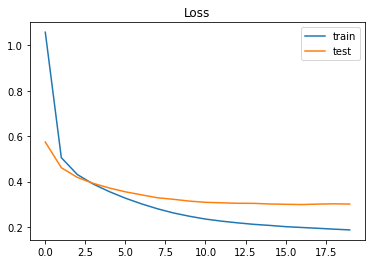

In [31]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [32]:
history.history

{'accuracy': [0.8122680187225342,
  0.8945106267929077,
  0.9079247117042542,
  0.9126131534576416,
  0.9171062111854553,
  0.9210783243179321,
  0.9236178994178772,
  0.9266783595085144,
  0.9290226101875305,
  0.9315621256828308,
  0.93338543176651,
  0.9362505674362183,
  0.9368366003036499,
  0.9369017481803894,
  0.9387249946594238,
  0.9397017359733582,
  0.9406785368919373,
  0.9406133890151978,
  0.9415901303291321,
  0.9430878162384033],
 'loss': [1.057598352432251,
  0.5055028200149536,
  0.43114468455314636,
  0.3890385031700134,
  0.3557899296283722,
  0.3271094560623169,
  0.30226245522499084,
  0.2804730534553528,
  0.26208215951919556,
  0.24749153852462769,
  0.235091432929039,
  0.22602801024913788,
  0.21847717463970184,
  0.21200701594352722,
  0.20720839500427246,
  0.20176061987876892,
  0.19811904430389404,
  0.19458192586898804,
  0.1908450722694397,
  0.1873825639486313],
 'val_accuracy': [0.8758054971694946,
  0.902167558670044,
  0.9080258011817932,
  0.909783

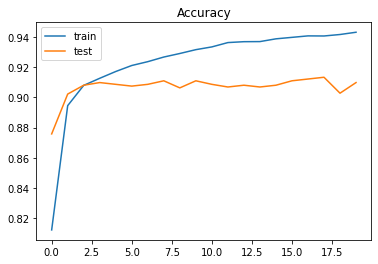

In [33]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

# **Testing**

In [34]:
input_text = ['رونالدو لاعب في نادي مانشستر يونايتد']
seq = t.texts_to_sequences(input_text)

labels = np.unique(labels)
for encoded_word in seq[0]:
    print('Word: ', t.index_word[encoded_word])
    pred = model.predict([encoded_word])
    print('\nPredictions probability for each class: \n', pred)
    print('\nPredicted Class: ', labels[np.argmax(pred)])
    print('\n***************************\n')


Word:  رونالدو

Predictions probability for each class: 
 [[6.2490911e-03 2.1239633e-05 3.7301951e-03 7.1184760e-01 2.7533497e-03
  7.4077706e-04 1.6986320e-04 2.7434221e-01 1.4563392e-04]]

Predicted Class:  B-PER

***************************

Word:  لاعب

Predictions probability for each class: 
 [[1.28803458e-05 5.50209297e-05 2.84630572e-04 4.15634349e-05
  1.33548965e-05 5.09788151e-05 1.21390431e-05 5.04447053e-05
  9.99478996e-01]]

Predicted Class:  O

***************************

Word:  في

Predictions probability for each class: 
 [[3.8262697e-05 2.3748606e-05 1.0638003e-05 1.4398799e-04 1.8926448e-04
  1.3366078e-04 2.5006619e-05 1.1938981e-04 9.9931610e-01]]

Predicted Class:  O

***************************

Word:  نادي

Predictions probability for each class: 
 [[1.7421192e-03 4.9323854e-03 5.5308628e-01 4.6089533e-04 2.2777903e-03
  1.0229316e-02 7.2687745e-02 6.7667384e-04 3.5390675e-01]]

Predicted Class:  B-ORG

***************************

Word:  مانشستر

Predictions 